# VIX9D Volatility Prediction using LSTM

This notebook implements an LSTM model to predict the Cboe S&P 500 Index 9-Day Volatility Index (VIX9D).

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

## Configuration

In [8]:
FILEPATH = '../data/VIX9D_History-SP500.csv'
SEQ_LENGTH = 60
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
HIDDEN_SIZE = 50
NUM_LAYERS = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

Using device: cpu


## Data Processing Functions

In [9]:
def load_data(filepath):
    """
    Load data from CSV file.
    Args:
        filepath (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with parsed dates.
    """
    df = pd.read_csv(filepath)
    # Strip whitespace from column names just in case
    df.columns = df.columns.str.strip()
    
    # Parse dates
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
    df = df.sort_values('DATE').reset_index(drop=True)
    return df

class VIXDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

def create_sequences(data, seq_length):
    """
    Create sequences for LSTM.
    Args:
        data (np.array): Scaled data (num_samples, num_features).
        seq_length (int): Length of the sequence.
    Returns:
        np.array, np.array: Sequences (X) and Targets (y).
    """
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length] # Predict the next step
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def preprocess_data(df, target_cols=['OPEN', 'HIGH', 'LOW', 'CLOSE'], seq_length=60, train_split=0.8):
    """
    Preprocess data: normalize and split.
    Args:
        df (pd.DataFrame): Dataframe.
        target_col (str): Column to predict.
        seq_length (int): Window size.
        train_split (float): Split ratio.
    Returns:
        dict: Contains train_loader, val_loader, scaler, train/val datasets
    """
    data = df[target_cols].values
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = create_sequences(scaled_data, seq_length)
    
    train_size = int(len(X) * train_split)
    
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    
    train_dataset = VIXDataset(X_train, y_train)
    val_dataset = VIXDataset(X_val, y_val)
    
    return {
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'scaler': scaler,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val
    }

## Model Architecture

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=50, num_layers=2, output_size=4, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output from the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out

## Training and Evaluation

In [11]:
# Load and preprocess data
if not os.path.exists(FILEPATH):
    print(f"Error: File not found at {FILEPATH}")
else:
    df = load_data(FILEPATH)
    data_dict = preprocess_data(df, target_cols=['OPEN', 'HIGH', 'LOW', 'CLOSE'], seq_length=SEQ_LENGTH)
    
    train_dataset = data_dict['train_dataset']
    val_dataset = data_dict['val_dataset']
    scaler = data_dict['scaler']
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Model Setup
    model = LSTMModel(input_size=4, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=4)
    model = model.to(DEVICE)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training Loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    print("Starting training...")
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), '../results/models/best_model.pth')
    
    print("Training complete. Best Val Loss:", best_val_loss)

Starting training...
Epoch [5/10], Train Loss: 0.0014, Val Loss: 0.0012
Epoch [10/10], Train Loss: 0.0010, Val Loss: 0.0009
Training complete. Best Val Loss: 0.0008553256878561418


## Visualizing Results

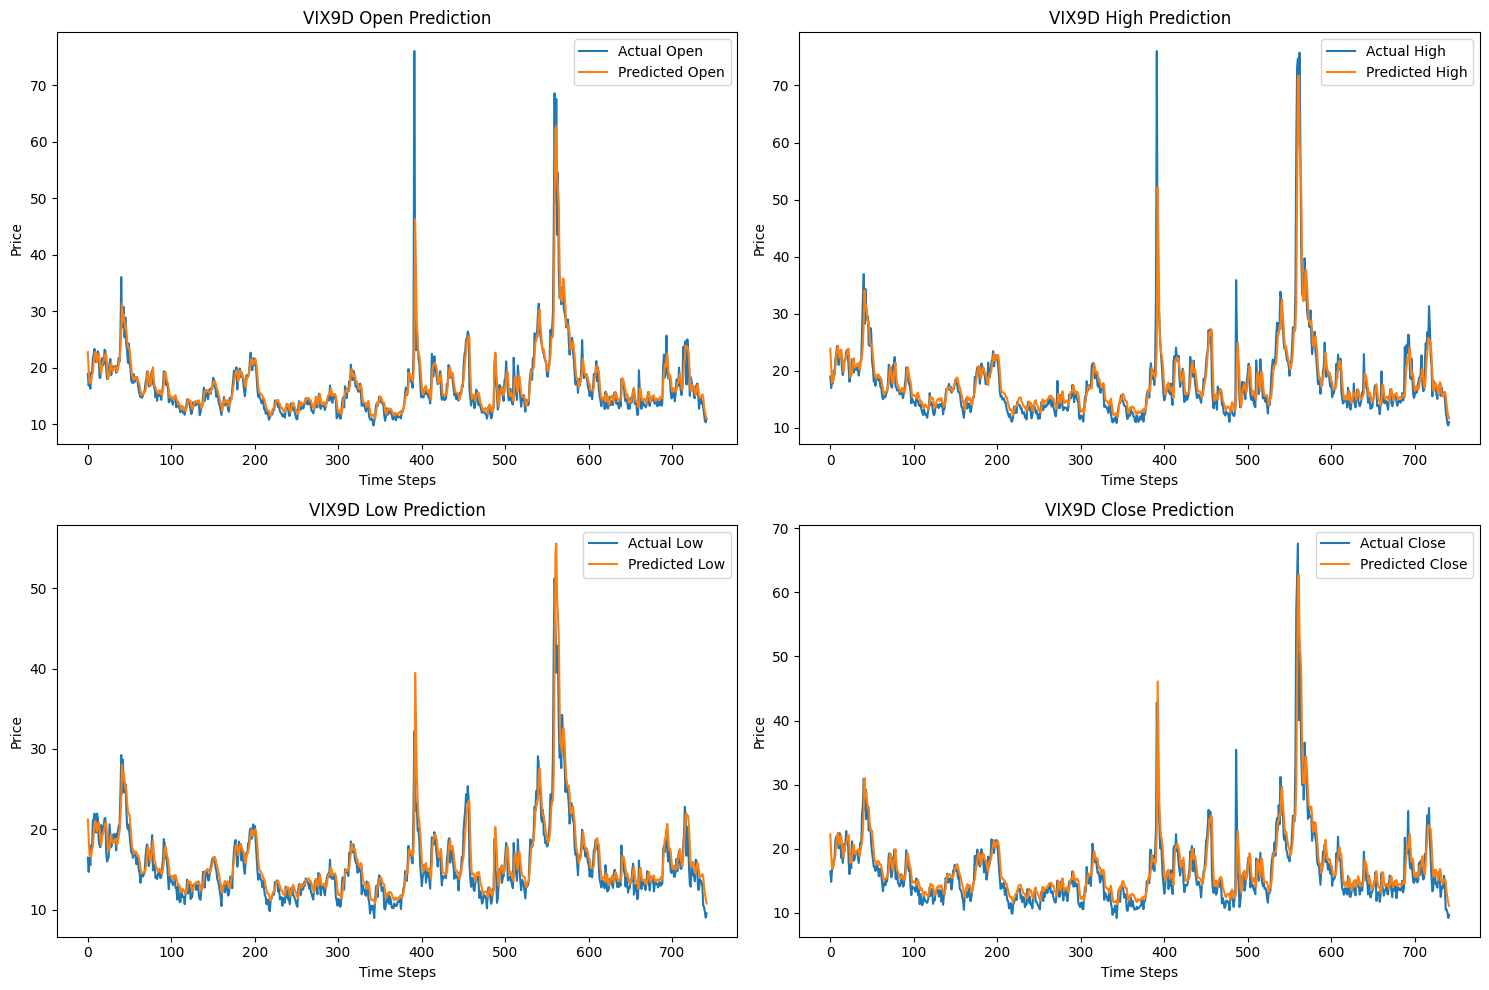

In [12]:
# Final Evaluation on Val Set
model.load_state_dict(torch.load('../results/models/best_model.pth', weights_only=True))
model.eval()

# Get all val predictions
X_val = torch.FloatTensor(data_dict['X_val']).to(DEVICE)
y_val = data_dict['y_val']

with torch.no_grad():
    preds = model(X_val).cpu().numpy()

# Inverse transform
preds_actual = scaler.inverse_transform(preds)
actual_y = scaler.inverse_transform(y_val)

# Plot Actual vs Predicted for all 4 features
features = ['Open', 'High', 'Low', 'Close']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].plot(actual_y[:, i], label=f'Actual {feature}')
    axes[i].plot(preds_actual[:, i], label=f'Predicted {feature}')
    axes[i].set_title(f'VIX9D {feature} Prediction')
    axes[i].set_xlabel('Time Steps')
    axes[i].set_ylabel('Price')
    axes[i].legend()

plt.tight_layout()
plt.show()